# AML Final Project 

### Initial Stage for Data Pre-Processing

In [23]:
# All Imports
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [24]:
# Reading the files
train = pd.read_csv('train/train.csv')
breed_labels = pd.read_csv('breed_labels.csv')
color_labels = pd.read_csv('color_labels.csv')
state_labels = pd.read_csv('state_labels.csv')

In [25]:
# Merging three file contents to TrainNew.CSV (BreedNames, Color & State addition)
# Create Mappings (ID -> Name)
# We use mapping dictionaries for faster and cleaner merging
breed_map = breed_labels.set_index('BreedID')['BreedName']
color_map = color_labels.set_index('ColorID')['ColorName']
state_map = state_labels.set_index('StateID')['StateName']

# Map the Values
# Breeds
train['Breed1Name'] = train['Breed1'].map(breed_map)
train['Breed2Name'] = train['Breed2'].map(breed_map)

# Colors
train['Color1Name'] = train['Color1'].map(color_map)
train['Color2Name'] = train['Color2'].map(color_map)
train['Color3Name'] = train['Color3'].map(color_map)

# State
train['StateName'] = train['State'].map(state_map)

In [26]:

# Reorder columns: place name columns right after their ID columns

def insert_after(df, col_to_move, anchor_col):
    """
    Moves `col_to_move` to immediately after `anchor_col` in DataFrame `df`.
    Skips silently if either column is missing.
    """
    if col_to_move in df.columns and anchor_col in df.columns:
        series = df.pop(col_to_move)
        anchor_idx = df.columns.get_loc(anchor_col)
        df.insert(anchor_idx + 1, col_to_move, series)

# Breeds
insert_after(train, "Breed1Name", "Breed1")
insert_after(train, "Breed2Name", "Breed2")

# Colors (optional)
insert_after(train, "Color1Name", "Color1")
insert_after(train, "Color2Name", "Color2")
insert_after(train, "Color3Name", "Color3")

# State — add this line
insert_after(train, "StateName", "State")

In [27]:
# Handle Missing Values (Optional but recommended for a clean file)
# If a second breed or color is missing (ID=0), map returns NaN. We fill these with 'None'.
train['Breed2Name'] = train['Breed2Name'].fillna('None')
train['Color2Name'] = train['Color2Name'].fillna('None')
train['Color3Name'] = train['Color3Name'].fillna('None')

In [28]:
# Drop rows where Quantity > 1
if "Quantity" in train.columns:
    # Drop rows where Quantity > 1
    original_rows = len(train)
    train = train[train["Quantity"] <= 1]
    removed_rows = original_rows - len(train)
    print(f"Removed {removed_rows} rows where Quantity > 1.")
else:
    print("Column 'Quantity' not found in train.csv.")

Removed 3428 rows where Quantity > 1.


In [29]:
# Drop Name and Quantity columns if they exist
cols_to_drop = ["Name","RescuerID","Quantity"]

# Only drop columns that are present to avoid errors
train = train.drop(columns=[c for c in cols_to_drop if c in train.columns])

In [30]:
# Save the unified file
train.to_csv('train_new.csv', index=False)

print("Successfully created 'train_new.csv' with mapped labels.")

Successfully created 'train_new.csv' with mapped labels.


### Second Stage of Data Cleaning & Imputation

In [31]:
# Duplicate Check & Missing Values Overview
input_file = "train_new.csv"
df = pd.read_csv(input_file)
# 1) Duplicate checks
dup_all = df.duplicated(keep=False)
print(f"Duplicate rows (exact matches): {dup_all.sum()}")

if "PetID" in df.columns:
    dup_petid = df["PetID"].duplicated(keep=False)
    dup_ids = df.loc[df["PetID"].duplicated(), "PetID"].unique()
    print(f"Rows with duplicate PetID: {dup_petid.sum()}")
    print(f"Example duplicate PetIDs (up to 10): {list(dup_ids)[:10]}")

# 2) Missing values overview
missing_counts = df.isna().sum()
missing_pct = (missing_counts / len(df) * 100).round(2)
missing_table = (
    pd.DataFrame({"column": df.columns,
                  "missing_count": missing_counts.values,
                  "missing_pct": missing_pct.values})
    .sort_values("missing_pct", ascending=False)
)
print("\nTop missing-value columns:")
print(missing_table.head(15))

# Save reports
#missing_table.to_csv("missing_values_report.csv", index=False)

# 3) Simple imputation recommendations (no changes yet)
nums = df.select_dtypes(include=[np.number]).columns.tolist()
recs = []
for col in df.columns:
    mc = int(missing_counts[col])
    if mc == 0: 
        continue
    dtype = "numeric" if col in nums else "categorical"
    strategy = "median" if dtype == "numeric" else "mode"
    recs.append({"column": col, "dtype": dtype, "missing_count": mc, "missing_pct": float(missing_pct[df.columns.get_loc(col)]), "suggested_impute": strategy})

#pd.DataFrame(recs).to_csv("impute_recommendations.csv", index=False)
#print("\nSaved: missing_values_report.csv, impute_recommendations.csv")


Duplicate rows (exact matches): 0
Rows with duplicate PetID: 0
Example duplicate PetIDs (up to 10): []

Top missing-value columns:
         column  missing_count  missing_pct
12   Color3Name           9029        78.07
5    Breed2Name           8491        73.42
10   Color2Name           3978        34.40
23  Description              9         0.08
3    Breed1Name              4         0.03
0          Type              0         0.00
16     Dewormed              0         0.00
25     PhotoAmt              0         0.00
24        PetID              0         0.00
22     VideoAmt              0         0.00
21    StateName              0         0.00
20        State              0         0.00
19          Fee              0         0.00
18       Health              0         0.00
17   Sterilized              0         0.00


/var/folders/0g/xfzq1f8n1kj3213nx65mz0y80000gn/T/ipykernel_60252/2418035111.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recs.append({"column": col, "dtype": dtype, "missing_count": mc, "missing_pct": float(missing_pct[df.columns.get_loc(col)]), "suggested_impute": strategy})


### Feature Engineering

In [32]:
#FinalBreed
# --- 1) Load data ---
input_file = "train_new.csv"
train = pd.read_csv(input_file)
#print(f"Loaded: {input_file} | rows={len(train)}")

# --- 2) Ensure numeric IDs for reliable checks ---
for c in ["Breed1", "Breed2"]:
    if c in train.columns:
        train[c] = pd.to_numeric(train[c], errors="coerce")

# --- 3) Resolve breed name columns (auto-detect) ---
def first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

breed1_name_col = first_existing(train, ["Breed1Name", "PrimaryBreedName"])
breed2_name_col = first_existing(train, ["Breed2Name", "SecondaryBreedName"])

# Normalize names (lowercase, trimmed) if present; else create empty strings
def norm_text(s):
    if pd.isna(s): return ""
    return str(s).lower().strip().replace('"', '').replace("'", "")

if breed1_name_col:
    train["Breed1Name_norm"] = train[breed1_name_col].apply(norm_text)
else:
    train["Breed1Name_norm"] = ""

if breed2_name_col:
    train["Breed2Name_norm"] = train[breed2_name_col].apply(norm_text)
else:
    train["Breed2Name_norm"] = ""

# --- 4) Helper: detect 'mix' or 'mixed' (word-level)
mix_pattern = re.compile(r"\bmix(ed)?\b")

def has_mix(name: str) -> bool:
    if not name: return False
    return bool(mix_pattern.search(name))

# --- 5) Compute finalbreed (0=Purebred, 1=HighClassMixed, 2=Mixed1, 3=Mixed2) ---
def compute_finalbreed(row):
    b1 = row.get("Breed1")
    b2 = row.get("Breed2")
    b1_present = pd.notna(b1) and b1 != 0
    b2_present = pd.notna(b2) and b2 != 0

    b1_mix = has_mix(row.get("Breed1Name_norm", ""))
    b2_mix = has_mix(row.get("Breed2Name_norm", ""))

    # --- Mixed2 rules ---
    # a) Breed1 has 'mix' (regardless of Breed2), OR
    # b) Either name has 'mix' and the other breed is missing, OR
    # c) Both names contain 'mix'
    if (b1_mix and not b2_present) or (b2_mix and not b1_present) or (b1_mix and b2_mix) or b1_mix:
        return 3

    # --- Mixed1 ---
    if b2_present and b1_present and b2_mix and not b1_mix:
        return 2

    # --- HighClassMixed ---
    if b1_present and b2_present and (b1 != b2) and (not b1_mix) and (not b2_mix):
        return 1

    # --- Purebred cases ---
    if b1_present and not b1_mix and not b2_present:
        return 0
    if (not b1_present) and b2_present and not b2_mix:
        return 0

    # Fallback
    return 0

train["FinalBreed"] = train.apply(compute_finalbreed, axis=1)

# --- 6) Preview: first 12 rows with relevant columns ---
preview_cols = [c for c in [
    "PetID", "Breed1", breed1_name_col, "Breed1Name_norm",
    "Breed2", breed2_name_col, "Breed2Name_norm", "finalbreed"
] if c and c in train.columns]
print("\nPreview (first 12 rows):")
print(train[preview_cols].head(5))

# --- 7) Counts per class ---
print("\nClass counts (finalbreed):")
print(train["FinalBreed"].value_counts().sort_index().to_string())

# --- 8) Examples per class from your own CSV (first 5 each) ---
examples = []
for code, label in [(0, "purebred"), (1, "highclassmixed"), (2, "mixed1"), (3, "mixed2")]:
    sub = train[train["FinalBreed"] == code].copy()
    if not sub.empty:
        sub["_class"] = label
        examples.append(sub.head(3))

if examples:
    ex = pd.concat(examples, ignore_index=True)
    ex_cols = [c for c in ["PetID", "Breed1", breed1_name_col, "Breed2", breed2_name_col, "FinalBreed", "_class"] if c and c in ex.columns]
    print("\nExamples per class:")
    print(ex[ex_cols])


cols_to_remove = ["Breed1Name_norm", "Breed2Name_norm"]
train = train.drop(columns=cols_to_remove, errors="ignore")

# --- 9) (Optional) Save after you review ---
# train.to_csv("train_with_finalbreed.csv", index=False)
# print("Saved -> train_with_finalbreed.csv")



Preview (first 12 rows):
       PetID  Breed1            Breed1Name       Breed1Name_norm  Breed2  \
0  86e1089a3     299                 Tabby                 tabby       0   
1  6296e909a     265  Domestic Medium Hair  domestic medium hair       0   
2  3422e4906     307           Mixed Breed           mixed breed       0   
3  5842f1ff5     307           Mixed Breed           mixed breed       0   
4  850a43f90     307           Mixed Breed           mixed breed       0   

  Breed2Name Breed2Name_norm  
0        NaN                  
1        NaN                  
2        NaN                  
3        NaN                  
4        NaN                  

Class counts (finalbreed):
FinalBreed
0    5143
1    1156
2     634
3    4632

Examples per class:
        PetID  Breed1            Breed1Name  Breed2            Breed2Name  \
0   86e1089a3     299                 Tabby       0                   NaN   
1   6296e909a     265  Domestic Medium Hair       0                   NaN   


In [33]:
# Color Diversity
# Load your dataset
# Ensure numeric for color columns
for c in ["Color1", "Color2", "Color3"]:
    if c in train.columns:
        train[c] = pd.to_numeric(train[c], errors="coerce")

# Compute ColorDiversity
def compute_color_diversity(row):
    colors = [row.get("Color1"), row.get("Color2"), row.get("Color3")]
    # Count non-zero and non-NaN values
    count = sum(1 for c in colors if pd.notna(c) and c != 0)
    if count <= 1:
        return 1
    elif count == 2:
        return 2
    else:
        return 3

train["ColorDiversity"] = train.apply(compute_color_diversity, axis=1)

# Quick preview
#print(train[["Color1", "Color2", "Color3", "ColorDiversity"]].head(10))

# (Optional) Save after inspection
# train.to_csv("train_with_colordiversity.csv", index=False)



In [34]:
#Fully Healthy Column & Removal of Reduntant ID Columns
# Check if all four columns equal 1 for each row
train['Fully_Healthy'] = (train[['Vaccinated', 'Dewormed', 'Sterilized', 'Health']] == 1).all(axis=1).astype(int)

# Drop Name and Quantity columns if they exist
cols_to_drop = ["Breed1","Breed2","Color1","Color2","Color3","State"]

# Only drop columns that are present to avoid errors
train = train.drop(columns=[c for c in cols_to_drop if c in train.columns])

In [35]:
# Save the unified file
train.to_csv('train_fe.csv', index=False)

print("Successfully created 'train_fe.csv' with mapped labels.")

Successfully created 'train_fe.csv' with mapped labels.


In [36]:
# Trying creating Age Bins for Two - Interaction Features. Will not keep the AgeGroup column. Also - Creating DescLength Column
# Create AgeGroup column
df = pd.read_csv("train_fe.csv")
df['AgeGroup'] = pd.cut(df['Age'],
                         bins=[-1, 6, 24, float('inf')],
                         labels=['Puppy', 'Adult', 'Senior'])

# 2 Interaction Features
df['AgeGroup_Breed1'] = df['AgeGroup'].astype(str) + '_' + df['Breed1Name'].astype(str)
df['AgeGroup_Color1'] = df['AgeGroup'].astype(str) + '_' + df['Color1Name'].astype(str)

df = df.drop(columns=['AgeGroup','Fully_Healthy'])

df['DescLength'] = df['Description'].apply(lambda x: len(str(x).split()))
#df['HasPhoto'] = (df['PhotoAmt'] > 0).astype(int)

# Save updated file
df.to_csv("training.csv", index=False)

### Tabular ML Algorithms & Modeling

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


#### Random Forest

Accuracy from Random Forest: 0.43233895373973197


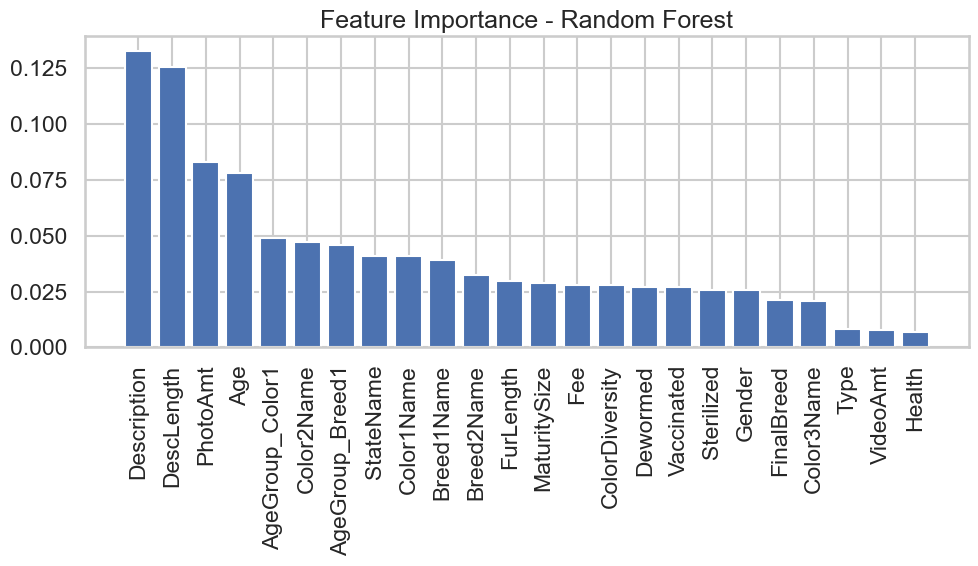

In [38]:
# Load your dataset
df = pd.read_csv("training.csv")

# Separate features and target
X = df.drop(columns=['AdoptionSpeed', 'PetID'])
y = df['AdoptionSpeed']

# Encode categorical columns
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
rf_preds = rf.predict(X_test)
print("Accuracy from Random Forest:", accuracy_score(y_test, rf_preds))

# Get feature importances from the trained RandomForest model
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


#### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 9252, number of used features: 24
[LightGBM] [Info] Start training from score -3.552865
[LightGBM] [Info] Start training from score -1.556498
[LightGBM] [Info] Start training from score -1.296620
[LightGBM] [Info] Start training from score -1.510910
[LightGBM] [Info] Start training from score -1.323054
LightGBM Accuracy: 0.4275832252485949
              precision    recall  f1-score   support

           0       0.40      0.09      0.15        66
           1       0.40      0.37      0.38       488
           2       0.36      0.41      0.38       633
           3       0.40      0.27      0.32       510
           4       0.52      0.66      0.58       616

    accuracy  

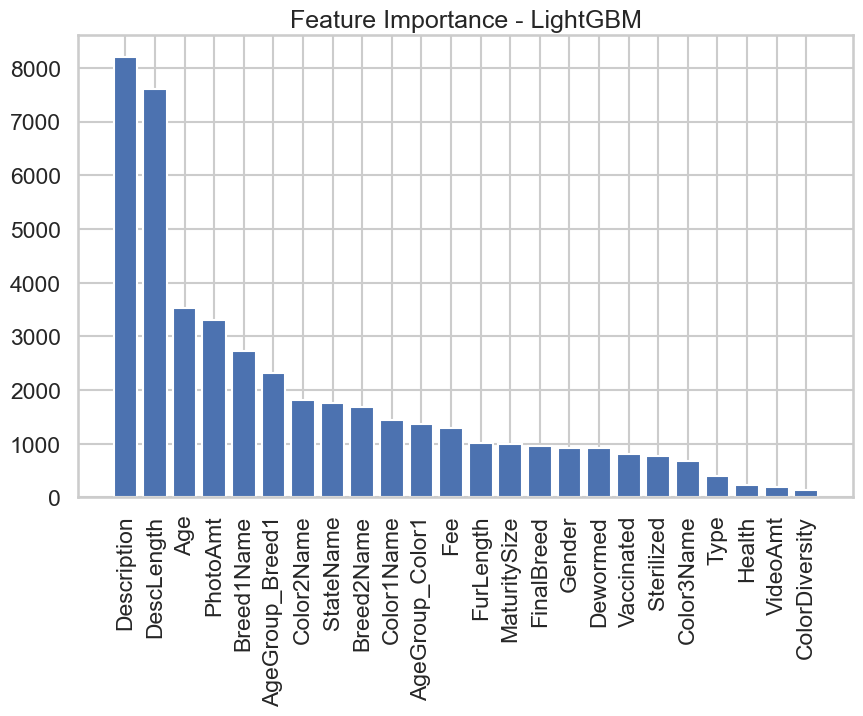

In [39]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, lgb_preds))
print(classification_report(y_test, lgb_preds))

# Feature Importance
importances = lgb_model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.title("Feature Importance - LightGBM")
plt.show()


#### XGBoost

/opt/anaconda3/envs/pythonproject/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.41418071768266324
              precision    recall  f1-score   support

           0       0.42      0.08      0.13        66
           1       0.36      0.34      0.35       488
           2       0.36      0.43      0.39       633
           3       0.39      0.24      0.30       510
           4       0.51      0.64      0.57       616

    accuracy                           0.41      2313
   macro avg       0.41      0.34      0.35      2313
weighted avg       0.41      0.41      0.40      2313



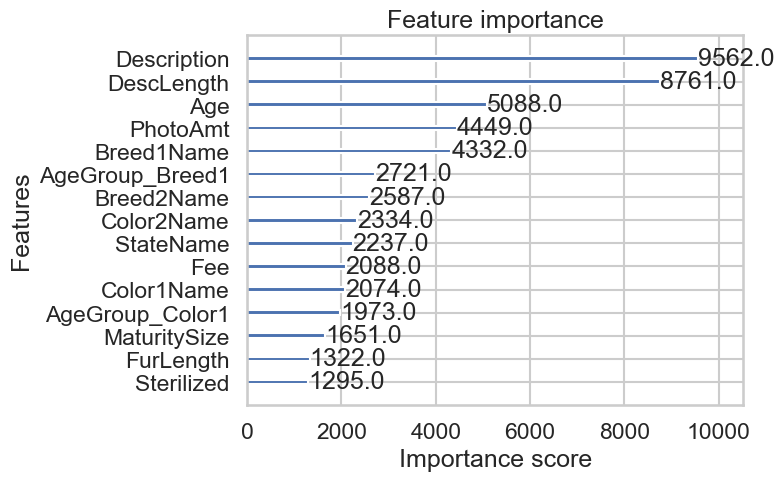

In [40]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

# Feature Importance
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model, max_num_features=15)
plt.show()


In [41]:
# Hyperparameter Tuning for XGBoost
from sklearn.model_selection import GridSearchCV

# After encoding categorical features and splitting data:
# X_train, X_test, y_train, y_test are ready

# Define parameter grid
params = {
    'n_estimators': [200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Initialize GridSearchCV
grid = GridSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=params,
    cv=3,
    scoring='accuracy',
    verbose=1
)

# Fit the grid search
grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid.best_params_)

# Train final model with best params
best_xgb = grid.best_estimator_
best_xgb.fit(X_train, y_train)

# Evaluate
preds = best_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300}
Accuracy: 0.43060959792477305
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        66
           1       0.36      0.35      0.36       488
           2       0.38      0.43      0.40       633
           3       0.42      0.29      0.34       510
           4       0.53      0.65      0.59       616

    accuracy                           0.43      2313
   macro avg       0.44      0.36      0.36      2313
weighted avg       0.43      0.43      0.42      2313



### CatBoost with K-Folds

In [42]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier


# Initialize K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
accuracies = []

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # CatBoost model
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='Accuracy',
        verbose=False,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    acc = accuracy_score(y_val, preds)
    accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    fold += 1

print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")



Fold 1 Accuracy: 0.4220
Fold 2 Accuracy: 0.4336
Fold 3 Accuracy: 0.4090
Fold 4 Accuracy: 0.4254
Fold 5 Accuracy: 0.3887

Average Accuracy: 0.4157


[info] Loading: training.csv
[info] Generating visuals...


/var/folders/0g/xfzq1f8n1kj3213nx65mz0y80000gn/T/ipykernel_60252/1346602804.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=d, x="AgeGroup", order=order, palette="Blues")


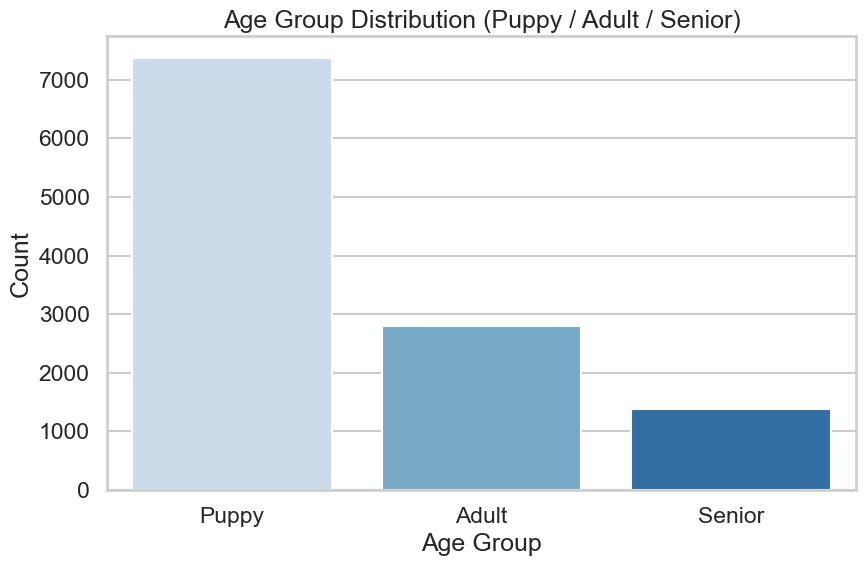

/var/folders/0g/xfzq1f8n1kj3213nx65mz0y80000gn/T/ipykernel_60252/1346602804.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=d, x="_FinalBreedLabel", order=order, palette="viridis")


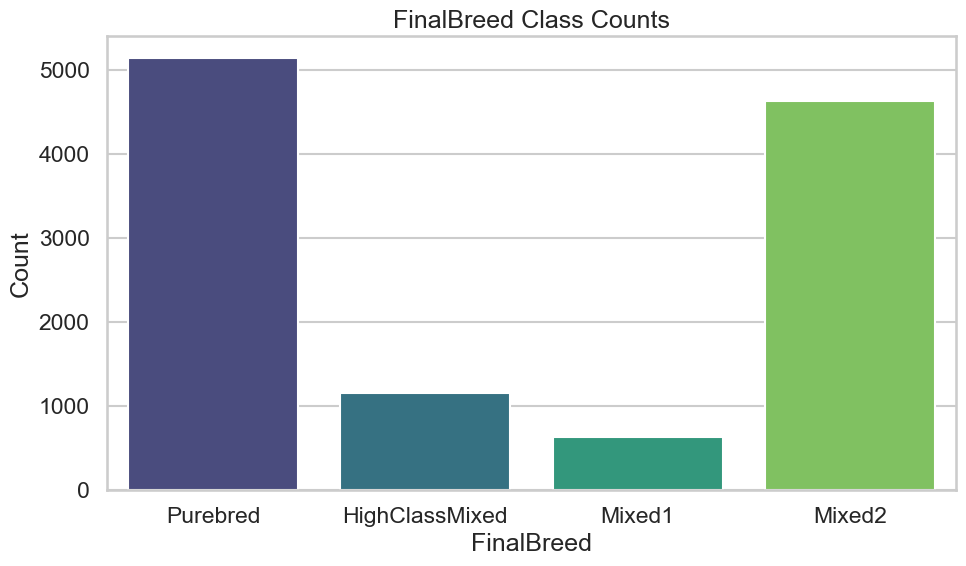

/var/folders/0g/xfzq1f8n1kj3213nx65mz0y80000gn/T/ipykernel_60252/1346602804.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values * 100, y=vc.index, palette="viridis")


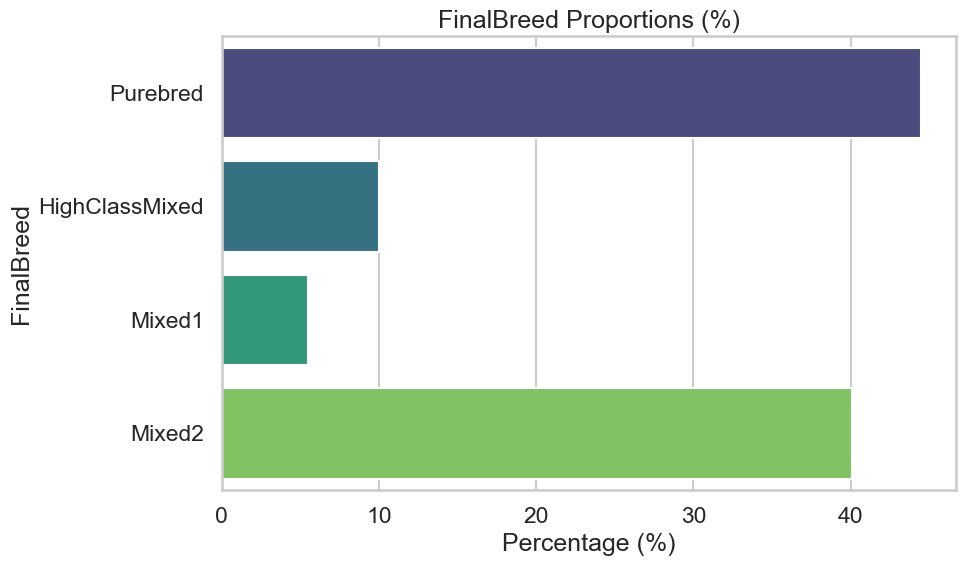

/var/folders/0g/xfzq1f8n1kj3213nx65mz0y80000gn/T/ipykernel_60252/1346602804.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speed_counts.index.astype(str), y=speed_props.values, ax=ax[0], palette="Set2")


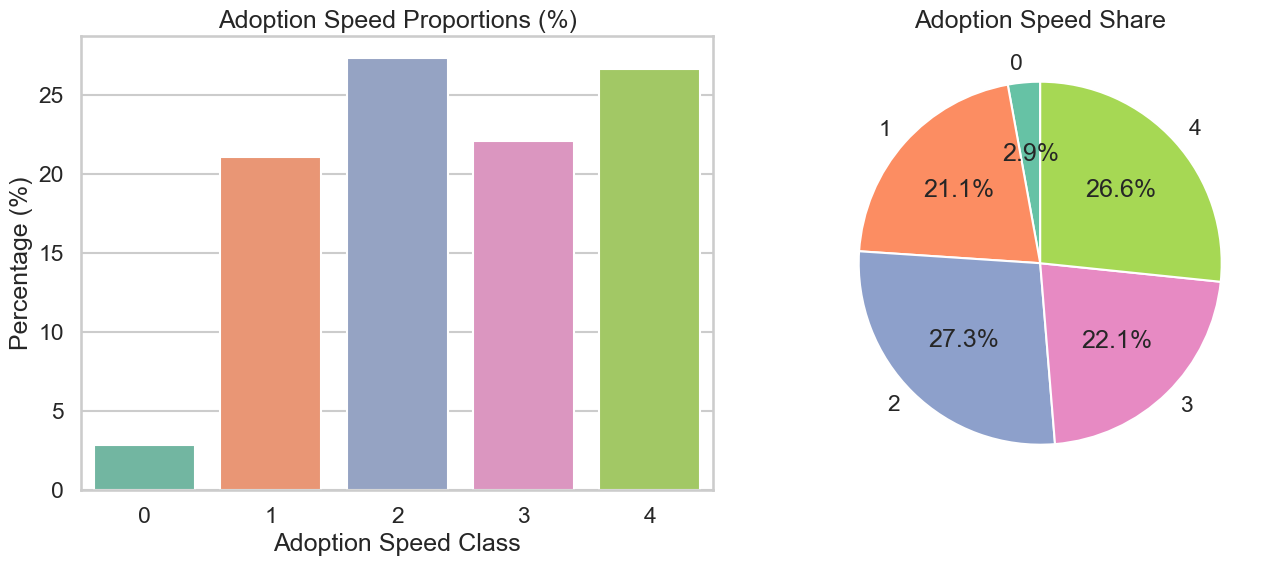

[done] Visuals complete.


In [45]:

# viz_core_distributions.py
# Core distribution visuals: Age group histogram, FinalBreed counts, AdoptionSpeed proportions
# Compatible with your pipeline files: train_fe.csv and training.csv
#
# Usage:
#   python viz_core_distributions.py            # auto-detects available file
#   python viz_core_distributions.py training.csv
#   python viz_core_distributions.py train_fe.csv
#
# Requirements: pandas, matplotlib, seaborn
# (These are standard; install via pip if needed: pip install pandas matplotlib seaborn)

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# --- Helper: load whichever file is present ---
def load_data(path_arg=None):
    candidates = []
    if path_arg:
        candidates.append(path_arg)
    # Prefer the later-stage file if present, but support either
    candidates += ["training.csv", "train_fe.csv"]

    for p in candidates:
        if os.path.isfile(p):
            print(f"[info] Loading: {p}")
            return pd.read_csv(p), p
    raise FileNotFoundError(
        "Could not find training.csv or train_fe.csv in the current directory. "
        "Please supply a path argument."
    )

df, src_name = load_data(sys.argv[1] if len(sys.argv) > 1 else None)

# --- Ensure expected columns exist / recreate if needed ---
# AgeGroup binning per your PDF:
# bins = [-1, 6, 24, inf] -> labels: ['Puppy','Adult','Senior']  [1](https://utexas-my.sharepoint.com/personal/nk25627_eid_utexas_edu/Documents/Microsoft%20Copilot%20Chat%20Files/vertopal.com_AMLCodeNk.pdf)
def ensure_agegroup(d):
    if "Age" not in d.columns:
        raise ValueError("Column 'Age' not found; cannot build AgeGroup.")
    d["AgeGroup"] = pd.cut(
        d["Age"],
        bins=[-1, 6, 24, float("inf")],
        labels=["Puppy", "Adult", "Senior"]
    )
    return d

df = ensure_agegroup(df)

# FinalBreed was computed earlier in your pipeline and saved (as 'FinalBreed').  [1](https://utexas-my.sharepoint.com/personal/nk25627_eid_utexas_edu/Documents/Microsoft%20Copilot%20Chat%20Files/vertopal.com_AMLCodeNk.pdf)
if "FinalBreed" not in df.columns:
    raise ValueError(
        "Column 'FinalBreed' not found. Please run your feature engineering step "
        "that creates FinalBreed before visualizing."
    )

# AdoptionSpeed is your target in training.csv; keep proportions visualization flexible.  [1](https://utexas-my.sharepoint.com/personal/nk25627_eid_utexas_edu/Documents/Microsoft%20Copilot%20Chat%20Files/vertopal.com_AMLCodeNk.pdf)
if "AdoptionSpeed" not in df.columns:
    raise ValueError(
        "Column 'AdoptionSpeed' not found. Ensure you're loading 'training.csv' "
        "or a file that retains the target."
    )

# --- Plotting functions ---
def plot_agegroup_hist(d):
    plt.figure(figsize=(9, 6))
    # Show count of records in each AgeGroup (acts as a histogram by bins)
    order = ["Puppy", "Adult", "Senior"]
    sns.countplot(data=d, x="AgeGroup", order=order, palette="Blues")
    plt.title("Age Group Distribution (Puppy / Adult / Senior)")
    plt.xlabel("Age Group")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_finalbreed_counts(d):
    # Map numeric codes to readable labels per your PDF definition  [1](https://utexas-my.sharepoint.com/personal/nk25627_eid_utexas_edu/Documents/Microsoft%20Copilot%20Chat%20Files/vertopal.com_AMLCodeNk.pdf)
    label_map = {
        0: "Purebred",
        1: "HighClassMixed",
        2: "Mixed1",
        3: "Mixed2"
    }
    d["_FinalBreedLabel"] = d["FinalBreed"].map(label_map).fillna(d["FinalBreed"].astype(str))

    plt.figure(figsize=(10, 6))
    order = ["Purebred", "HighClassMixed", "Mixed1", "Mixed2"]
    sns.countplot(data=d, x="_FinalBreedLabel", order=order, palette="viridis")
    plt.title("FinalBreed Class Counts")
    plt.xlabel("FinalBreed")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Optional: horizontal bar with percentages
    vc = d["_FinalBreedLabel"].value_counts(normalize=True).reindex(order)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=vc.values * 100, y=vc.index, palette="viridis")
    plt.title("FinalBreed Proportions (%)")
    plt.xlabel("Percentage (%)")
    plt.ylabel("FinalBreed")
    plt.tight_layout()
    plt.show()

def plot_adoptionspeed_proportions(d):
    # Bar proportions
    speed_counts = d["AdoptionSpeed"].value_counts().sort_index()
    speed_props = (speed_counts / speed_counts.sum()) * 100

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(x=speed_counts.index.astype(str), y=speed_props.values, ax=ax[0], palette="Set2")
    ax[0].set_title("Adoption Speed Proportions (%)")
    ax[0].set_xlabel("Adoption Speed Class")
    ax[0].set_ylabel("Percentage (%)")

    # Pie chart for the same proportions
    ax[1].pie(
        speed_counts.values,
        labels=[str(i) for i in speed_counts.index],
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("Set2", n_colors=len(speed_counts))
    )
    ax[1].set_title("Adoption Speed Share")

    plt.tight_layout()
    plt.show()

# --- Run visuals ---
print("[info] Generating visuals...")
plot_agegroup_hist(df)
plot_finalbreed_counts(df)
plot_adoptionspeed_proportions(df)
print("[done] Visuals complete.")


/var/folders/0g/xfzq1f8n1kj3213nx65mz0y80000gn/T/ipykernel_60252/4084803708.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AgeGroup', data=df, palette='Blues')


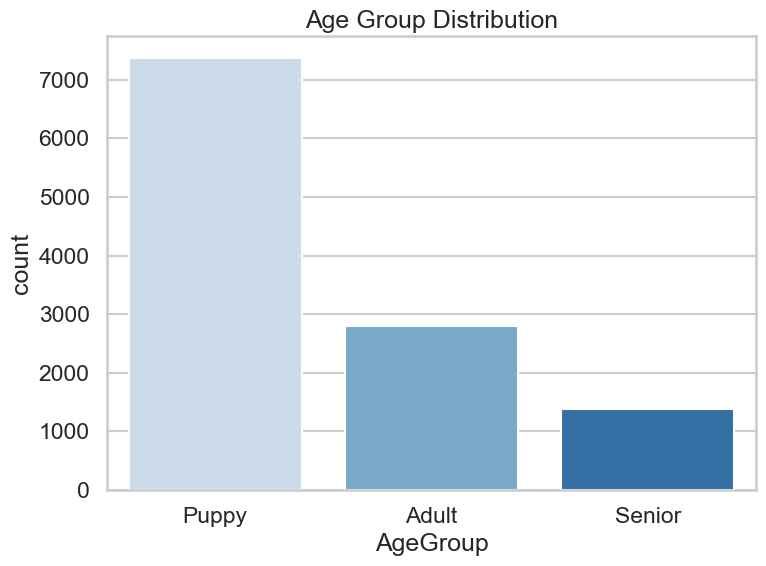

/var/folders/0g/xfzq1f8n1kj3213nx65mz0y80000gn/T/ipykernel_60252/4084803708.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FinalBreed', data=df, palette='viridis')


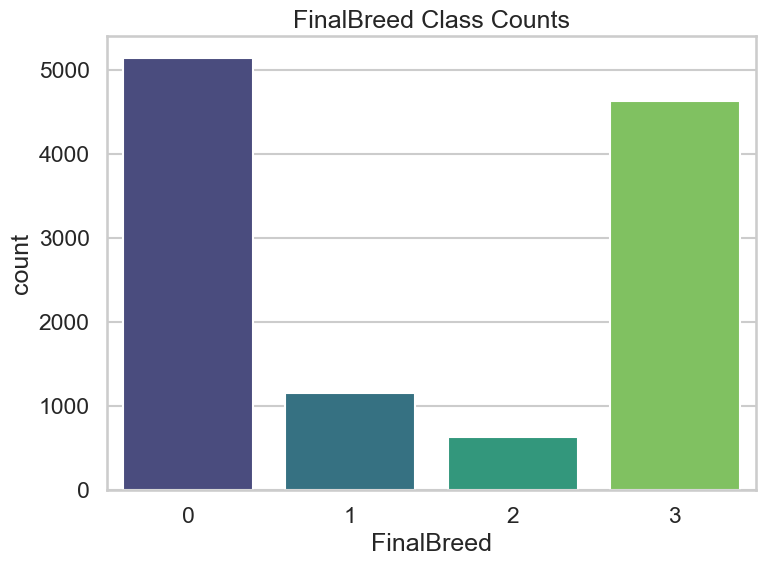

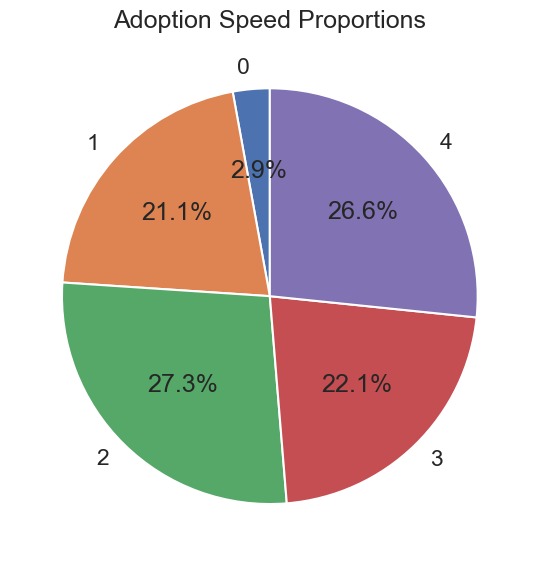

In [47]:

# AgeGroup Histogram
plt.figure(figsize=(8, 6))
sns.countplot(x='AgeGroup', data=df, palette='Blues')
plt.title('Age Group Distribution')
plt.tight_layout()
plt.savefig('agegroup_histogram.png', dpi=300)  # Save as PNG
plt.show()

# FinalBreed Counts
plt.figure(figsize=(8, 6))
sns.countplot(x='FinalBreed', data=df, palette='viridis')
plt.title('FinalBreed Class Counts')
plt.tight_layout()
plt.savefig('finalbreed_counts.jpeg', dpi=300)  # Save as JPEG
plt.show()

# AdoptionSpeed Proportions
adoption_counts = df['AdoptionSpeed'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.pie(adoption_counts, labels=adoption_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Adoption Speed Proportions')
plt.tight_layout()
plt.savefig('adoptionspeed_proportions.png', dpi=300)  # Save as PNG
plt.show()
